In [46]:
# import analysis library
import pandas as pd, numpy as np 
import seaborn  as sns
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
plt.style.use('ggplot')


Populating the interactive namespace from numpy and matplotlib


## 1) Load data

In [77]:
df_iris=pd.read_csv('iris.csv')

In [78]:
df_iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
Id               150 non-null int64
SepalLengthCm    150 non-null float64
SepalWidthCm     150 non-null float64
PetalLengthCm    150 non-null float64
PetalWidthCm     150 non-null float64
Species          150 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 7.1+ KB


In [79]:
df_iris['Species'].value_counts()

Iris-virginica     50
Iris-setosa        50
Iris-versicolor    50
Name: Species, dtype: int64

In [80]:
df_iris.head(3)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa


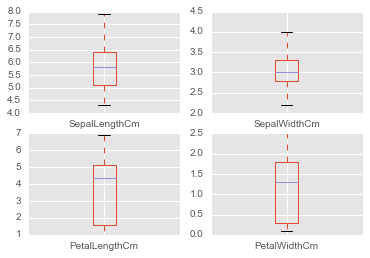

In [86]:
df_iris.iloc[:,1:5].plot(kind='box',layout=(2,2), subplots=True,sharex=False, sharey=False)
plt.show()

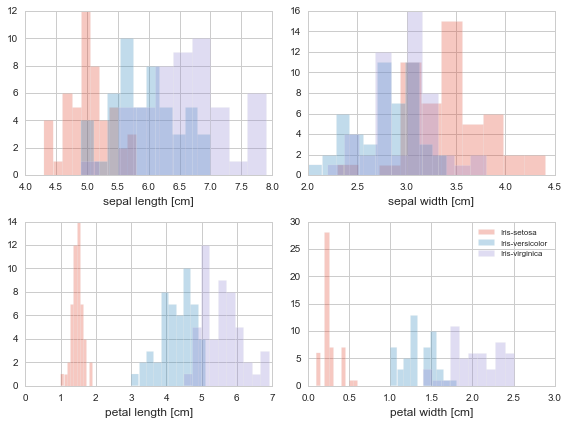

In [50]:
# visualize data points in histagram 

X = df_iris.ix[:,1:5].values
y = df_iris.ix[:,5].values


feature_dict = {0: 'sepal length [cm]',
                1: 'sepal width [cm]',
                2: 'petal length [cm]',
                3: 'petal width [cm]'}

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 6))
    for cnt in range(4):
        plt.subplot(2, 2, cnt+1)
        for lab in ('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'):
            plt.hist(X[y==lab, cnt],
                     label=lab,
                     bins=10,
                     alpha=0.3,)
        plt.xlabel(feature_dict[cnt])
    plt.legend(loc='upper right', fancybox=True, fontsize=8)

    plt.tight_layout()
    plt.show()

#### From visualization above we can learn that : 
- `petal length/width` seems can classify iris in species better than `sepal length/width`, while different species data points overlap in sepal but not in petal case

- It's possible predict species solely via `petal length/width` feature
- Can use `PCA` extract important main features rather than put all features in 

## 2) Dara preprocess

In [87]:
#df_iris.head(2)

In [12]:
#df_iris['species'] = df_iris.map(lambda x : 0 if x== 'Iris-virginica',
#                                            1 if x== 'Iris-setosa',
#                                            2 if x== 'Iris-versicolor'
#                                for x in df_iris.Species )
#df_iris['species'] = df_iris.map(lambda x :  0 if x== 'Iris-virginica')
#df_iris.map(lambda X: x == 'Iris-virginica', df_iris.Species))

In [89]:
def species_encode(x):
    if x == 'Iris-virginica':
        return 0 
    if x == 'Iris-setosa':
        return 1 
    if x == 'Iris-versicolor':
        return 2

In [90]:
df_iris['species_'] =  df_iris.Species.map(lambda x : species_encode(x))

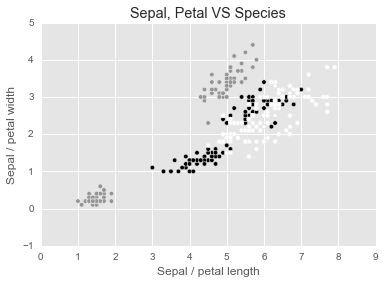

In [91]:
plt.scatter(df_iris.iloc[:,1:2],df_iris.iloc[:,2:3],c=df_iris.species_)
plt.scatter(df_iris.iloc[:,3:4],df_iris.iloc[:,4:5],c=df_iris.species_)

#plt.legend(set(df_iris.Species),loc='best')
plt.title('Sepal, Petal VS Species')
plt.xlabel('Sepal / petal length')
plt.ylabel('Sepal / petal width')
plt.show()

- Plot all data points in same plot (Sepal/Petal Length/Width)
- Again, Petal seems a better feature than Sepal in species classification  from the data distribution plot above

### 2-1) PCA (Principal component analysis)

#### Have to standardize features before PCA, since treat too big/small features same in PCA would affect the output (eigenvectors and eigenvalues) 

In [55]:
X = df_iris.iloc[:,1:5]

from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

In [47]:
from sklearn.decomposition import PCA as sklearnPCA

In [57]:
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_std)

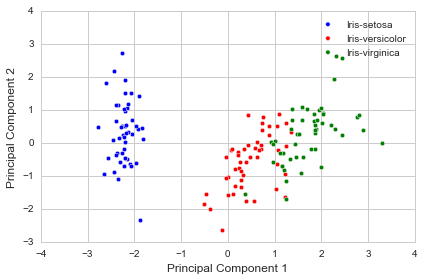

In [62]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'), 
                        ('blue', 'red', 'green')):
        plt.scatter(Y_sklearn[y==lab, 0],
                    Y_sklearn[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

#### After PCA :
 - We can now using only 2 main transformed features represent original data pattern 
 - The PCA features looks work fine, data points in different species are seperated good. Using simple models like `logistics regression` or `KNN` approaching classification may be a good choice 

In [17]:
df_iris.head(2)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,species_
0,1,5.1,3.5,1.4,0.2,Iris-setosa,1
1,2,4.9,3.0,1.4,0.2,Iris-setosa,1


## 3) ML

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score


def train(df,model):
    df_ = df.copy()
    X = df_.iloc[:,1:5]
    y = df_.iloc[:,6:7]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    clf_ = model.fit(X_train, y_train)
    print ('test score :', model.score(X_test,y_test) )
    y_true = y_test
    y_pred = clf_.predict(X_test)
    print ('-------------------')
    print ('confusion matrix : ')
    print (confusion_matrix(y_true, y_pred))
    print ('-------------------')
    print ('classification report  : ')
    print (classification_report(y_true, y_pred))
    #print (clf_)
    return clf_
       

### 3-1) Decision Tree

In [118]:
from sklearn.tree import DecisionTreeClassifier

clf_tree = tree.DecisionTreeClassifier()
clf_tree_ = train(df_iris,clf_tree )

test score : 0.98
-------------------
confusion matrix : 
[[15  0  1]
 [ 0 19  0]
 [ 0  0 15]]
-------------------
classification report  : 
             precision    recall  f1-score   support

          0       1.00      0.94      0.97        16
          1       1.00      1.00      1.00        19
          2       0.94      1.00      0.97        15

avg / total       0.98      0.98      0.98        50



### 3-2) Random Forest

In [111]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier()
clf_rf_ = train(df_iris,clf_rf )

test score : 0.98
-------------------
confusion matrix : 
[[15  0  1]
 [ 0 19  0]
 [ 0  0 15]]
-------------------
classification report  : 
             precision    recall  f1-score   support

          0       1.00      0.94      0.97        16
          1       1.00      1.00      1.00        19
          2       0.94      1.00      0.97        15

avg / total       0.98      0.98      0.98        50



//anaconda/envs/g_dash/lib/python3.4/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


### 3-3) Logistic Regression

In [112]:
from sklearn import linear_model
clf_logistic = linear_model.LogisticRegression(C=1e5)
clf_logistic_ = train(df_iris,clf_logistic )

test score : 0.98
-------------------
confusion matrix : 
[[15  0  1]
 [ 0 19  0]
 [ 0  0 15]]
-------------------
classification report  : 
             precision    recall  f1-score   support

          0       1.00      0.94      0.97        16
          1       1.00      1.00      1.00        19
          2       0.94      1.00      0.97        15

avg / total       0.98      0.98      0.98        50



//anaconda/envs/g_dash/lib/python3.4/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### 3-4) Ensemble Models

In [99]:
def ensemble_model(df,model1,model2,model3):
    df_ = df.copy()
    X = df_.iloc[:,1:5]
    y = df_.iloc[:,6:7]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    prediction = pd.DataFrame()
    prediction = y_test.reset_index()
    prediction['predict1'] = model1.predict(X_test)
    prediction['predict2'] = model2.predict(X_test)
    prediction['predict3'] = model3.predict(X_test)
    # ensemble : voting 
    prediction['predict_ensemble'] = prediction.iloc[:,2:5].mode(axis=1)
    print (prediction.head(3))
    print (confusion_matrix(prediction.species_, prediction.predict_ensemble))
    print (classification_report(prediction.species_, prediction.predict_ensemble))
    #print ('enseble score :' )
    return prediction
    

In [113]:
clf1 = clf_tree_
clf2 = clf_rf_
clf3 = clf_logistic_

In [114]:
predict_ensemble_ = ensemble_model(df_iris,clf1,clf2,clf3)

   index  species_  predict1  predict2  predict3  predict_ensemble
0     73         2       2.0         2         2               2.0
1     18         1       1.0         1         1               1.0
2    118         0       0.0         0         0               0.0
[[15  0  1]
 [ 0 19  0]
 [ 0  0 15]]
             precision    recall  f1-score   support

          0       1.00      0.94      0.97        16
          1       1.00      1.00      1.00        19
          2       0.94      1.00      0.97        15

avg / total       0.98      0.98      0.98        50



In [26]:
#from sklearn.ensemble import BaggingClassifier
#from sklearn.ensemble import VotingClassifier
#clf1 = clf_tree_
#clf2 = clf_rf_
#clf3 = clf_logistic_
#eclf = VotingClassifier(estimators=[('tree', clf1), ('rf', clf2), ('logistic', clf3)], voting='hard')


In [116]:
"""

def predict(*tupleCustomArgs):
    for k in tupleCustomArgs:
        print (k)
        
def predict_(*tupleCustomArgs):
    for k in tupleCustomArgs:
        print (k)
        
tupleCustomArgs = ("custom param1", "custom param2", "custom param3")
y = ["custom param1", "custom param2", "custom param3"]
z = [1,23,2342342]
predict(z)

"""

'\n\ndef predict(*tupleCustomArgs):\n    for k in tupleCustomArgs:\n        print (k)\n        \ndef predict_(*tupleCustomArgs):\n    for k in tupleCustomArgs:\n        print (k)\n        \ntupleCustomArgs = ("custom param1", "custom param2", "custom param3")\ny = ["custom param1", "custom param2", "custom param3"]\nz = [1,23,2342342]\npredict(z)\n\n'

###  3-5) Test on various models  

In [98]:
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

seed = 7
scoring = 'accuracy'

df_iris_ = df_iris.copy()
X = df_iris_.iloc[:,1:5]
y = df_iris_.iloc[:,6:7]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train,y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

//anaconda/envs/g_dash/lib/python3.4/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda/envs/g_dash/lib/python3.4/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda/envs/g_dash/lib/python3.4/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda/envs/g_dash/lib/python3.4/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

LR: 0.950000 (0.050000)
LDA: 0.980000 (0.040000)
KNN: 0.940000 (0.066332)
CART: 0.930000 (0.100499)
NB: 0.940000 (0.080000)
SVM: 0.950000 (0.067082)


//anaconda/envs/g_dash/lib/python3.4/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda/envs/g_dash/lib/python3.4/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda/envs/g_dash/lib/python3.4/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda/envs/g_dash/lib/python3.4/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t